In [1]:
#STACKING MODEL OF ALL TREES RF,XGB,LGBM AND ETC as META LEARNER, HIGH RECALL-0.83 , F1-0.73
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import (
    accuracy_score, classification_report,
    precision_score, recall_score, f1_score
)
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
# 1. Load and clean data
df=pd.read_csv("..\data\ibm_attrition.csv")

df.dropna(inplace=True)

In [3]:
# 2. Drop non-informative columns and high correlation columns
df.drop(columns=['EmployeeCount', 'Over18', 'StandardHours'], inplace=True)

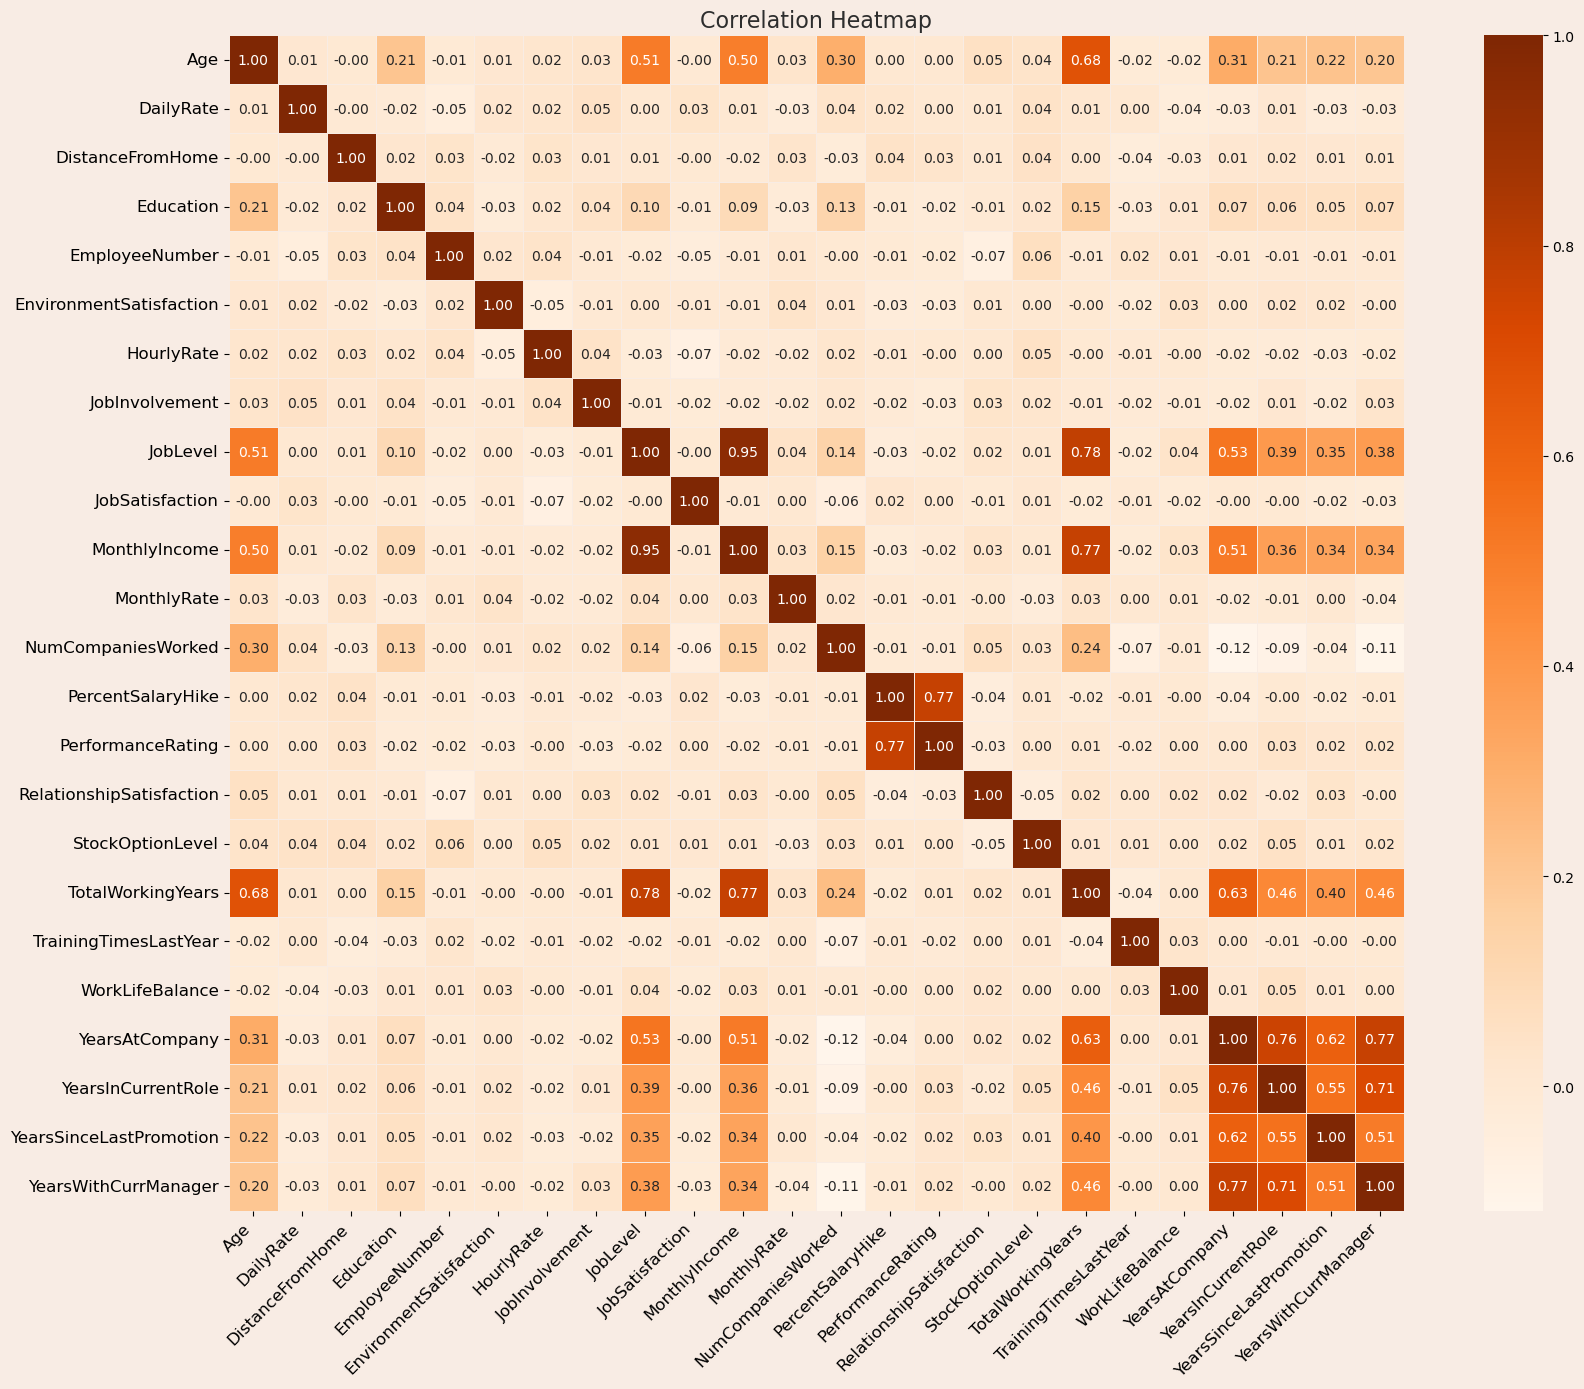

In [4]:
# Compute correlation matrix for numeric columns only
corr = df.select_dtypes(include='number').corr()

# Plot correlation heatmap with the same color theme
plt.figure(figsize=(12, 8), facecolor='#F8ECE4')
ax = plt.gca()
ax.set_facecolor('#F8ECE4')
plt.title("Correlation Heatmap", color='#2D2D2D', fontsize=16)
# Adjust annotation font size and heatmap cell size for better readability
sns.heatmap(
    corr, annot=True, fmt=".2f", cmap='Oranges', cbar=True,
    square=True, linewidths=0.5, linecolor='#F8ECE4',
    annot_kws={"size": 10}
)
plt.xticks(fontsize=12, rotation=45, ha='right')
plt.yticks(fontsize=12, rotation=0)
plt.gcf().set_size_inches(18, 14)
plt.tight_layout()
plt.show()

In [5]:
df.drop(columns=['MonthlyIncome'], inplace=True)

In [6]:
# 3. Encode categorical features
y = df["Attrition"].map({'Yes': 1, 'No': 0})
X = df.drop("Attrition", axis=1)

le = LabelEncoder()
for col in X.select_dtypes(include='object').columns:
    X[col] = le.fit_transform(X[col])
    

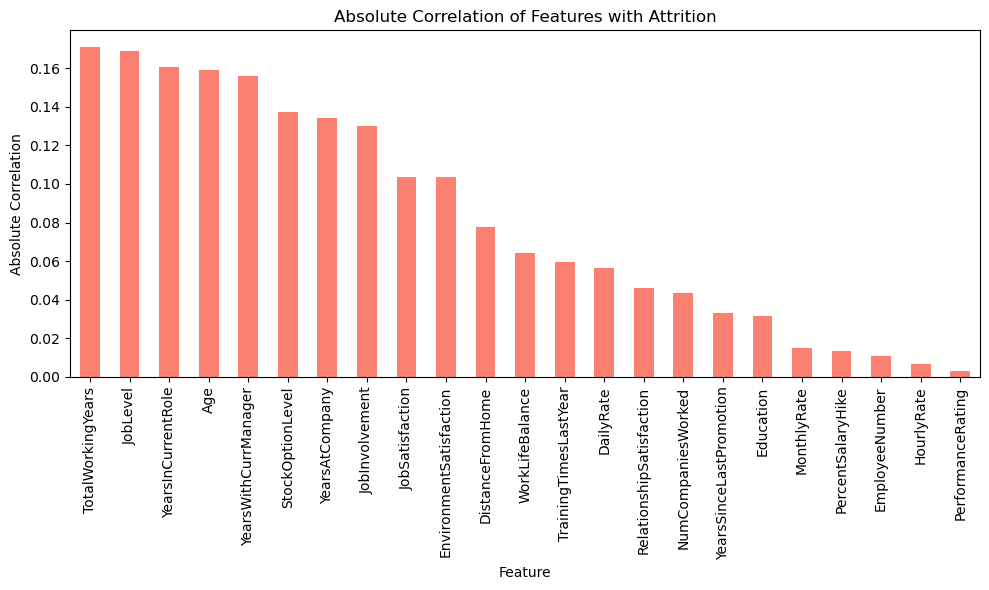

In [7]:
# Correlation heat bar plot for all numeric features with the target variable
numeric_cols = df.drop(columns=['Attrition']).select_dtypes(include=[np.number]).columns
corr_with_target = df[numeric_cols].apply(lambda x: np.corrcoef(x, y)[0, 1])
corr_with_target = corr_with_target.abs().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
corr_with_target.plot(kind='bar', color='salmon')
plt.title('Absolute Correlation of Features with Attrition')
plt.ylabel('Absolute Correlation')
plt.xlabel('Feature')
plt.tight_layout()
plt.show()


In [8]:
# 4. Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


In [9]:

# 5. Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [10]:

# 6. SMOTE for class imbalance
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)


In [11]:

# 7. Define base learners
base_learners = [
    ('rf', RandomForestClassifier(
        n_estimators=120, max_depth=5, min_samples_split=10, min_samples_leaf=5,
        max_features='sqrt', bootstrap=True, class_weight='balanced_subsample', random_state=42
    )),
    ('xgb', XGBClassifier(
        use_label_encoder=False, eval_metric='logloss', n_estimators=100,
        learning_rate=0.03, max_depth=3, subsample=0.6, colsample_bytree=0.6,
        scale_pos_weight=2, reg_lambda=10.0, reg_alpha=2.0, gamma=10.0, random_state=42
    )),
    ('lgb', LGBMClassifier(
        n_estimators=100, learning_rate=0.05, max_depth=5, subsample=0.7,
        colsample_bytree=0.7, class_weight='balanced', reg_lambda=5.0,
        reg_alpha=1.0, random_state=42
    ))
]

# 8. Define meta-learner
meta_learner = ExtraTreesClassifier(
    n_estimators=100, max_depth=6, min_samples_split=10,
    min_samples_leaf=5, max_features='sqrt', class_weight='balanced',
    random_state=42, n_jobs=-1
)

# 9. Define and train stacking model
stacking_model = StackingClassifier(
    estimators=base_learners,
    final_estimator=meta_learner,
    passthrough=True,
    cv=5,
    n_jobs=-1
)

stacking_model.fit(X_train_balanced, y_train_balanced)

# 🔍 Training Accuracy
y_train_pred = stacking_model.predict(X_train_balanced)
train_acc = accuracy_score(y_train_balanced, y_train_pred)
print(f"\n📚 Training Accuracy: {train_acc * 100:.2f}%")



📚 Training Accuracy: 94.98%


c:\Users\nishk\anaconda3\envs\py310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


c:\Users\nishk\anaconda3\envs\py310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



✅ Best Threshold: 0.280
🎯 Accuracy: 79.93%
🔁 Precision: 0.433
🔁 Recall: 0.830
🔁 F1-score: 0.569

📊 Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.79      0.87       247
           1       0.43      0.83      0.57        47

    accuracy                           0.80       294
   macro avg       0.70      0.81      0.72       294
weighted avg       0.88      0.80      0.82       294



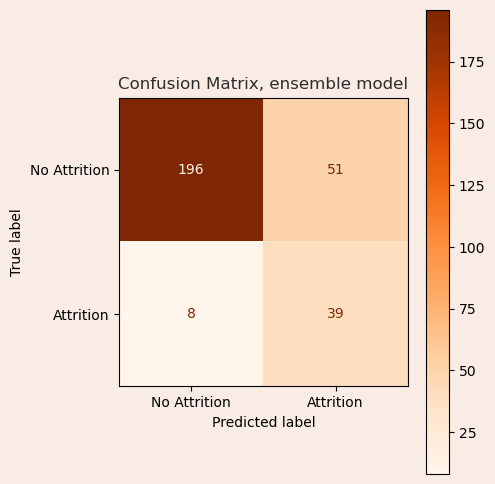

In [12]:

# 10. Evaluate
y_proba = stacking_model.predict_proba(X_test_scaled)[:, 1]

# Threshold tuning using Macro avg F1 score
thresholds = np.linspace(0.1, 0.9, 81)
best_macro_f1 = 0
best_thresh = 0
for thresh in thresholds:
    y_pred = (y_proba >= thresh).astype(int)
    macro_f1 = f1_score(y_test, y_pred, )
    if macro_f1 > best_macro_f1:
        best_macro_f1 = macro_f1
        best_thresh = thresh

# Final predictions
y_final = (y_proba >= best_thresh).astype(int)

# Report
print(f"\n✅ Best Threshold: {best_thresh:.3f}")
print(f"🎯 Accuracy: {accuracy_score(y_test, y_final) * 100:.2f}%")
print(f"🔁 Precision: {precision_score(y_test, y_final):.3f}")
print(f"🔁 Recall: {recall_score(y_test, y_final):.3f}")
print(f"🔁 F1-score: {f1_score(y_test, y_final):.3f}")
print("\n📊 Classification Report:")
print(classification_report(y_test, y_final))


cm = confusion_matrix(y_test, y_final)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Attrition', 'Attrition'])

# Set up a custom light salmon pink background
fig, ax = plt.subplots(figsize=(5, 5), facecolor='#F8ECE4')
ax.set_facecolor('#F8ECE4')

# Use a warm colormap, e.g., 'Oranges' or 'YlOrRd'
disp.plot(ax=ax, cmap='Oranges', values_format='d', colorbar=True)

plt.title("Confusion Matrix, ensemble model", color='#2D2D2D')
plt.grid(False)
plt.tight_layout()
plt.show()
